# Merge multisensor data

> This module groups all the functions used to merge together different data sources such as CML, Gauges or Radar.

In [ ]:
#| default_exp data.merge

In [ ]:
#| export
#| hide
import pandas as pd
import xarray as xr
from geopy.distance import geodesic

In [ ]:
#| hide
# Libraries for testing and visualization
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import patches
from shapely.geometry import LineString
from raincell.sample import open_cml_sample, open_gauge_sample
from nbdev.showdoc import *

## Gauges

Check the Sample data doc page to see how `cml` and `gauges` datasets are structured and what variables they contain.

In [ ]:
cml, gauges = open_cml_sample(),open_gauge_sample()

#### Nearest gauge to link path center

In [ ]:
#| hide
links = cml[["cml_id"]]
links

<xarray.Dataset> Size: 15kB
Dimensions:     (cml_id: 126)
Coordinates:
  * cml_id      (cml_id) <U19 10kB '3.984686N-9.789517E' ... '4.095631N-9.742...
    site_0_lat  (cml_id) float64 1kB 3.993 3.993 3.997 ... 4.087 4.092 4.094
    site_0_lon  (cml_id) float64 1kB 9.787 9.787 9.764 ... 9.766 9.729 9.742
    site_1_lat  (cml_id) float64 1kB 3.977 3.979 3.997 ... 4.095 4.091 4.097
    site_1_lon  (cml_id) float64 1kB 9.792 9.816 9.759 ... 9.764 9.736 9.743
    length      (cml_id) float64 1kB 1.852e+03 3.573e+03 556.0 ... 736.0 419.0
Data variables:
    *empty*
Attributes:
    title:                 East side Douala CML links sample data
    file author(s):        Orange Cameroun and IRD Rainsmore Group
    institution:           Orange Cameroun and IRD Rainsmore Group
    date:                  2025-11-07
    source:                Modified Orange Cameroun CML data for example purp...
    naming convention:     COST ACTION OPENSENSE V2
    license restrictions:  CC BY-NC-ND 4.0

In [ ]:
#| hide
links["center_lat"] = (links["site_0_lat"] + links["site_1_lat"]) / 2
links["center_lon"] = (links["site_0_lon"] + links["site_1_lon"]) / 2
links

<xarray.Dataset> Size: 17kB
Dimensions:     (cml_id: 126)
Coordinates:
  * cml_id      (cml_id) <U19 10kB '3.984686N-9.789517E' ... '4.095631N-9.742...
    site_0_lat  (cml_id) float64 1kB 3.993 3.993 3.997 ... 4.087 4.092 4.094
    site_0_lon  (cml_id) float64 1kB 9.787 9.787 9.764 ... 9.766 9.729 9.742
    site_1_lat  (cml_id) float64 1kB 3.977 3.979 3.997 ... 4.095 4.091 4.097
    site_1_lon  (cml_id) float64 1kB 9.792 9.816 9.759 ... 9.764 9.736 9.743
    length      (cml_id) float64 1kB 1.852e+03 3.573e+03 556.0 ... 736.0 419.0
Data variables:
    center_lat  (cml_id) float64 1kB 3.985 3.986 3.997 ... 4.091 4.092 4.096
    center_lon  (cml_id) float64 1kB 9.79 9.802 9.761 ... 9.765 9.733 9.743
Attributes:
    title:                 East side Douala CML links sample data
    file author(s):        Orange Cameroun and IRD Rainsmore Group
    institution:           Orange Cameroun and IRD Rainsmore Group
    date:                  2025-11-07
    source:                Modified Orange Cameroun CML data for example purp...
    naming convention:     COST ACTION OPENSENSE V2
    license restrictions:  CC BY-NC-ND 4.0

In [ ]:
#| hide
links_df = links.to_dataframe()[list(links.data_vars)]
links_df = links_df.rename(columns={"center_lat": "lat", "center_lon": "lon"})
links_df.head(2)

,lat,lon
cml_id,,
3.984686N-9.789517E,3.984686,9.789517
3.985691N-9.801648E,3.985691,9.801648


In [ ]:
#| exporti
def get_link_centers_opensense_v2(cml: xr.Dataset) -> pd.DataFrame:
    """Get the center coordinates of each link in the CML dataset for the V2 of the OpenSense standard."""
    links = cml[["site_0_lat", "site_0_lon", "site_1_lat", "site_1_lon"]]
    links["center_lat"] = (links["site_0_lat"] + links["site_1_lat"]) / 2
    links["center_lon"] = (links["site_0_lon"] + links["site_1_lon"]) / 2
    links = links.to_dataframe()[list(links.data_vars)]
    return links.rename(columns={"center_lat": "lat", "center_lon": "lon"})

In [ ]:
#| hide
links_df = get_link_centers_opensense_v2(cml)
links_df.head(2)

,lat,lon
cml_id,,
3.984686N-9.789517E,3.984686,9.789517
3.985691N-9.801648E,3.985691,9.801648


In [ ]:
#| hide
link = links_df.iloc[0]
link

lat    3.984686
lon    9.789517
Name: 3.984686N-9.789517E, dtype: float64

In [ ]:
#| exporti
def get_gauge_coords(
        gauges: xr.Dataset, # Dataset containing gauges coordinates
        lat: str = "gauge_lat", # Name of the latitude coordinate in the dataset
        lon: str = "gauge_lon" # Name of the longitude coordinate in the dataset
    ) -> pd.DataFrame:
    """Get the coordinates of each gauge in the gauges dataset."""
    gauges_metadata = gauges[[lat, lon]].to_dataframe()
    gauges_coords = gauges_metadata[[lat, lon]].rename(columns={lat: "lat", lon: "lon"})
    return gauges_coords

In [ ]:
#| hide
gauge_coords = get_gauge_coords(gauges)
gauge_coords.head(2)

,lat,lon
gauge_name,,
Campus_2_Universite,4.056639,9.742334
Ecole_Saint_Andre_PK11,4.056870,9.781641


In [ ]:
#| exporti
def haversine_distance(point1: pd.Series, point2: pd.Series) -> float:
    """Calculate the great circle distance between two points on Earth."""
    return geodesic((point1["lat"], point1["lon"]), (point2["lat"], point2["lon"])).kilometers

In [ ]:
#| hide
assert abs(haversine_distance(pd.Series({"lat": 0, "lon": 0}), pd.Series({"lat": 0, "lon": 1})) - 111.319) < 0.001

In [ ]:
#| hide
distances = gauge_coords.apply(haversine_distance, axis=1, point2=link)
distances.sort_values()

gauge_name
Lycee_NYALLA                  5.612400
Ecole_Saint_Andre_PK11        8.029850
SOCATUR                       8.475717
Meteo_IUT                     9.381050
Campus_2_Universite           9.526730
Piscine_CITE_SIC              9.896087
Eglise_Pie_X_PK14            10.461697
Hopital_des_Soeurs_Logpom    10.654718
dtype: float64

In [ ]:
#| hide
nearest_gauge = distances.idxmin()
nearest_gauge

'Lycee_NYALLA'

In [ ]:
#| hide
nearest_gauges = {cml_id: gauge_coords.apply(haversine_distance, axis=1, point2=l).idxmin() for cml_id, l in links_df.iterrows()}
dict(list(nearest_gauges.items())[:10:2])

{'3.984686N-9.789517E': 'Lycee_NYALLA',
 '3.996996N-9.761328E': 'Lycee_NYALLA',
 '4.007006N-9.767519E': 'Lycee_NYALLA',
 '4.013028N-9.703569E': 'Piscine_CITE_SIC',
 '4.014916N-9.732514E': 'SOCATUR'}

In [ ]:
#| hide
s = pd.Series(nearest_gauges.values(), index=nearest_gauges.keys(), name="gauge_name")
s.index.name = "cml_id"
s.head(2)

cml_id
3.984686N-9.789517E    Lycee_NYALLA
3.985691N-9.801648E    Lycee_NYALLA
Name: gauge_name, dtype: object

In [ ]:
#| hide
xr.merge([cml, gauges.sel(gauge_name=s.to_xarray())])

/tmp/ipykernel_112895/650186814.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  xr.merge([cml, gauges.sel(gauge_name=s.to_xarray())])


<xarray.Dataset> Size: 114MB
Dimensions:                  (cml_id: 126, sublink_id: 6, time: 2976)
Coordinates: (12/15)
  * cml_id                   (cml_id) <U19 10kB '3.984686N-9.789517E' ... '4....
  * sublink_id               (sublink_id) <U3 72B '0_0' '0_1' ... '2_0' '2_1'
  * time                     (time) datetime64[ns] 24kB 2019-07-01T00:05:00 ....
    frequency                (cml_id, sublink_id) float64 6kB 1.505e+04 ... nan
    site_0_lat               (cml_id) float64 1kB 3.993 3.993 ... 4.092 4.094
    site_0_lon               (cml_id) float64 1kB 9.787 9.787 ... 9.729 9.742
    ...                       ...
    length                   (cml_id) float64 1kB 1.852e+03 3.573e+03 ... 419.0
    gauge_code               (cml_id) int64 1kB 1059095002 ... 1059095005
    gauge_lat                (cml_id) float64 1kB 4.031 4.031 ... 4.057 4.079
    gauge_lon                (cml_id) float64 1kB 9.77 9.77 9.77 ... 9.742 9.768
    gauge_installation_type  (cml_id) <U10 5kB 'Dalle_sol' ... 'Dalle_sol'
    gauge_name               (cml_id) <U25 13kB 'Lycee_NYALLA' ... 'Hopital_d...
Data variables:
    rsl_avg                  (cml_id, sublink_id, time) float64 18MB -48.0 .....
    tsl_avg                  (cml_id, sublink_id, time) float64 18MB 10.0 ......
    rsl_min                  (cml_id, sublink_id, time) float64 18MB -48.8 .....
    tsl_min                  (cml_id, sublink_id, time) float64 18MB 10.0 ......
    rsl_max                  (cml_id, sublink_id, time) float64 18MB -47.6 .....
    tsl_max                  (cml_id, sublink_id, time) float64 18MB 10.0 ......
    tp                       (cml_id, time) float64 3MB 0.0 0.0 0.0 ... nan nan
    tprate                   (cml_id, time) float64 3MB 0.0 0.0 0.0 ... nan nan
Attributes:
    title:                 East side Douala CML links sample data
    file author(s):        Orange Cameroun and IRD Rainsmore Group
    institution:           Orange Cameroun and IRD Rainsmore Group
    date:                  2025-11-07
    source:                Modified Orange Cameroun CML data for example purp...
    naming convention:     COST ACTION OPENSENSE V2
    license restrictions:  CC BY-NC-ND 4.0

In [ ]:
#| export
def assign_nearest_gauge_to_link_center(
        cml: xr.Dataset, # CML dataset containing link information
        gauges: xr.Dataset, # Dataset containing gauges coordinates
        gauge_id: str = "gauge_name", # Name of the dimension of the gauge identifier in the gauges dataset
        gauge_lat: str = "gauge_lat", # Name of the latitude coordinate in the gauges dataset
        gauge_lon: str = "gauge_lon" # Name of the longitude coordinate in the gauges dataset
    ) -> xr.Dataset: # CML dataset merged with nearest gauge data and metadata
    """Assign the nearest gauge to each CML link based on geodesic distance from gauge to link center coordinates."""
    link_centers = get_link_centers_opensense_v2(cml)
    gauges_coords = get_gauge_coords(gauges)
    nearest_gauge = {cml_id: gauges_coords.apply(haversine_distance, axis=1, point2=ctr_coords).idxmin() for cml_id, ctr_coords in link_centers.iterrows()}
    nearest_gauge = pd.Series(nearest_gauge.values(), index=nearest_gauge.keys(), name=gauge_id)
    nearest_gauge.index.name = "cml_id"
    return xr.merge([cml, gauges.sel({gauge_id: nearest_gauge.to_xarray()})], join="outer")
    

In [ ]:
cml_with_gauges = assign_nearest_gauge_to_link_center(cml, gauges)
cml_with_gauges

<xarray.Dataset> Size: 114MB
Dimensions:                  (cml_id: 126, sublink_id: 6, time: 2976)
Coordinates: (12/15)
  * cml_id                   (cml_id) <U19 10kB '3.984686N-9.789517E' ... '4....
  * sublink_id               (sublink_id) <U3 72B '0_0' '0_1' ... '2_0' '2_1'
  * time                     (time) datetime64[ns] 24kB 2019-07-01T00:05:00 ....
    frequency                (cml_id, sublink_id) float64 6kB 1.505e+04 ... nan
    site_0_lat               (cml_id) float64 1kB 3.993 3.993 ... 4.092 4.094
    site_0_lon               (cml_id) float64 1kB 9.787 9.787 ... 9.729 9.742
    ...                       ...
    length                   (cml_id) float64 1kB 1.852e+03 3.573e+03 ... 419.0
    gauge_code               (cml_id) int64 1kB 1059095002 ... 1059095005
    gauge_lat                (cml_id) float64 1kB 4.031 4.031 ... 4.057 4.079
    gauge_lon                (cml_id) float64 1kB 9.77 9.77 9.77 ... 9.742 9.768
    gauge_installation_type  (cml_id) <U10 5kB 'Dalle_sol' ... 'Dalle_sol'
    gauge_name               (cml_id) <U25 13kB 'Lycee_NYALLA' ... 'Hopital_d...
Data variables:
    rsl_avg                  (cml_id, sublink_id, time) float64 18MB -48.0 .....
    tsl_avg                  (cml_id, sublink_id, time) float64 18MB 10.0 ......
    rsl_min                  (cml_id, sublink_id, time) float64 18MB -48.8 .....
    tsl_min                  (cml_id, sublink_id, time) float64 18MB 10.0 ......
    rsl_max                  (cml_id, sublink_id, time) float64 18MB -47.6 .....
    tsl_max                  (cml_id, sublink_id, time) float64 18MB 10.0 ......
    tp                       (cml_id, time) float64 3MB 0.0 0.0 0.0 ... nan nan
    tprate                   (cml_id, time) float64 3MB 0.0 0.0 0.0 ... nan nan
Attributes:
    title:                 East side Douala CML links sample data
    file author(s):        Orange Cameroun and IRD Rainsmore Group
    institution:           Orange Cameroun and IRD Rainsmore Group
    date:                  2025-11-07
    source:                Modified Orange Cameroun CML data for example purp...
    naming convention:     COST ACTION OPENSENSE V2
    license restrictions:  CC BY-NC-ND 4.0

In [ ]:
#| hide
links_with_gauges = cml_with_gauges.cml_id.to_dataframe() # to keep only cml and gauge metadata info
links_geo = gpd.GeoDataFrame(
    links_with_gauges["gauge_name"], 
    geometry=[LineString([(row.site_0_lon, row.site_0_lat), (row.site_1_lon, row.site_1_lat)]) for idx, row in links_with_gauges.iterrows()]
)
links_geo.head(2)

,gauge_name,geometry
cml_id,,
3.984686N-9.789517E,Lycee_NYALLA,"LINESTRING (9.78717 3.99272, 9.79187 3.97665)"
3.985691N-9.801648E,Lycee_NYALLA,"LINESTRING (9.78717 3.99272, 9.81613 3.97866)"


In [ ]:
#| hide
gauge_geo = gpd.GeoDataFrame(index=gauge_coords.index, geometry=gpd.points_from_xy(gauge_coords.lon, gauge_coords.lat))
gauge_geo

,geometry
gauge_name,
Campus_2_Universite,POINT (9.74233 4.05664)
Ecole_Saint_Andre_PK11,POINT (9.78164 4.05687)
Eglise_Pie_X_PK14,POINT (9.79472 4.07915)
Hopital_des_Soeurs_Logpom,POINT (9.76784 4.07855)
Lycee_NYALLA,POINT (9.76992 4.03147)
Meteo_IUT,POINT (9.74517 4.05689)
Piscine_CITE_SIC,POINT (9.7306 4.05183)
SOCATUR,POINT (9.74551 4.04731)


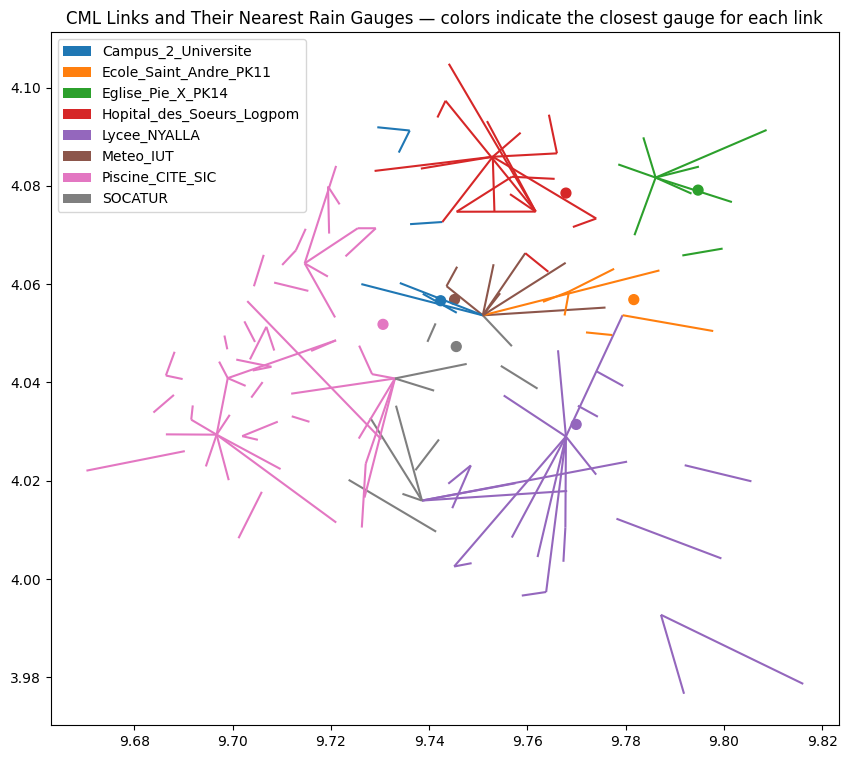

In [ ]:
#| echo: false
def assign_colors_by_gauge(g):
  colors = {
    'Campus_2_Universite': '#1f77b4',
    'Ecole_Saint_Andre_PK11': '#ff7f0e',
    'Eglise_Pie_X_PK14': '#2ca02c',
    'Hopital_des_Soeurs_Logpom': '#d62728',
    'Lycee_NYALLA': '#9467bd',
    'Meteo_IUT': '#8c564b',
    'Piscine_CITE_SIC': '#e377c2',
    'SOCATUR': '#7f7f7f'
  }
  return colors[g]

fig, ax = plt.subplots(figsize=(12, 9))
ax = links_geo.plot(ax=ax, color=[assign_colors_by_gauge(g) for g in links_geo["gauge_name"]])
ax = gauge_geo.plot(ax=ax, color=[assign_colors_by_gauge(g) for g in gauge_geo.index], markersize=50)
legend_elements = [patches.Patch(facecolor=assign_colors_by_gauge(g), label=g) for g in gauge_geo.index]
ax.legend(handles=legend_elements, loc='best')
ax.set_title("CML Links and Their Nearest Rain Gauges — colors indicate the closest gauge for each link");

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()